In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import boxcox1p        
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('max_colwidth',500)

In [10]:
data=pd.read_csv('loan.csv')

In [12]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


Dataset has 74 columns including the output columns 'loan_status'.

I created a dataframe from data dictionary so that evaluating each column will be easier. This dataframe shows feature name, decription, first value, data type and number of null values.

In [13]:
data_dict=pd.read_excel('LCDataDictionary.xlsx',sheet_name='LoanStats')

In [14]:
data_dict.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.


In [17]:
data_dtypes=pd.DataFrame(data.dtypes,columns=['dtype'])
data_dtypes.reset_index(inplace=True)
data_dtypes.columns=['LoanStatNew', 'dtype']
data_dtypes['first value'] = data.loc[0].values

In [18]:
data_dtypes.head()

,LoanStatNew,dtype,first value
0,id,object,1077501
1,member_id,float64,1296599.0
2,loan_amnt,float64,5000.0
3,funded_amnt,float64,5000.0
4,funded_amnt_inv,float64,4975.0


In [19]:
data_col=data_dtypes.merge(data_dict, on='LoanStatNew',how='left')

In [20]:
data_col.head(2)

,LoanStatNew,dtype,first value,Description
0,id,object,1077501,A unique LC assigned ID for the loan listing.
1,member_id,float64,1296599.0,A unique LC assigned Id for the borrower member.


In [21]:
d={'LoanStatNew':[],'Nulls':[]}
for i in data.columns:
    d['LoanStatNew'].append(i)
    d['Nulls'].append(len(data[data[i].isnull()][i]))
data_col=data_col.merge(pd.DataFrame(d),on='LoanStatNew')
nulls=pd.DataFrame(d)

In [23]:
data_col

,LoanStatNew,dtype,first value,Description,Nulls
0,id,object,1077501,A unique LC assigned ID for the loan listing.,4
1,member_id,float64,1296599.0,A unique LC assigned Id for the borrower member.,7
2,loan_amnt,float64,5000.0,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",7
3,funded_amnt,float64,5000.0,The total amount committed to that loan at that point in time.,7
4,funded_amnt_inv,float64,4975.0,The total amount committed by investors for that loan at that point in time.,7
...,...,...,...,...,...
106,tax_liens,float64,0.0,Number of tax liens,112
107,tot_hi_cred_lim,float64,NaN,Total high credit/credit limit,42542
108,total_bal_ex_mort,float64,NaN,Total credit balance excluding mortgage,42542
109,total_bc_limit,float64,NaN,Total bankcard high credit/credit limit,42542


Now I am able to see info of each column. With this info I decided which column to delete from model.

## Exploratory Data Analysis:

Here I will go throught important features and analyse them. We'll use this information while data cleaning as well as training machine learning model.

In [24]:
data_y=data['loan_status']

In [25]:
data_y.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Late (31-120 days)',
       'In Grace Period', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [27]:
data_y.value_counts()

Fully Paid                                             34085
Charged Off                                             5662
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Current                                                   19
Late (31-120 days)                                         9
In Grace Period                                            8
Late (16-30 days)                                          2
Default                                                    1
Name: loan_status, dtype: int64

**I considered Fully Paid loans and Charged off, Late (31-120 days), Default loans as these categories tells surely about loan repayment**

In [28]:
default=['Charged Off','Late (31-120 days)','Default']
data['loan_status']=data['loan_status'].apply(lambda x: 'Default' if x in default else x)

In [29]:
data_y.value_counts()

Fully Paid                                             34085
Default                                                 5672
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Current                                                   19
In Grace Period                                            8
Late (16-30 days)                                          2
Name: loan_status, dtype: int64

In [30]:
data=data[(data['loan_status']=='Default') | (data['loan_status']=='Fully Paid')]

Following are some important points about data:
1. Data is skewed with the ratio of **22/78**. That is, in 100 rows, only 22 rows refers to 'Default' case which is expected as defaulted cases will always be minimal.
2. Loan defaulters tend to apply for larger loans.
3. Around 23% of funded amount is defaulted

In [31]:
#Data is skewed with the ration of 21.84/78.16
data['loan_status'].value_counts()[0]/len(data['loan_status'])

0.8573332997962623

In [32]:
#relation between average loan amount and loan status
data[['loan_amnt','loan_status']].groupby(by='loan_status').mean()

#Loan defaulters tend to apply for larger loans.

,loan_amnt
loan_status,
Default,12150.185120
Fully Paid,11073.361449


<AxesSubplot:xlabel='loan_amnt', ylabel='loan_status'>

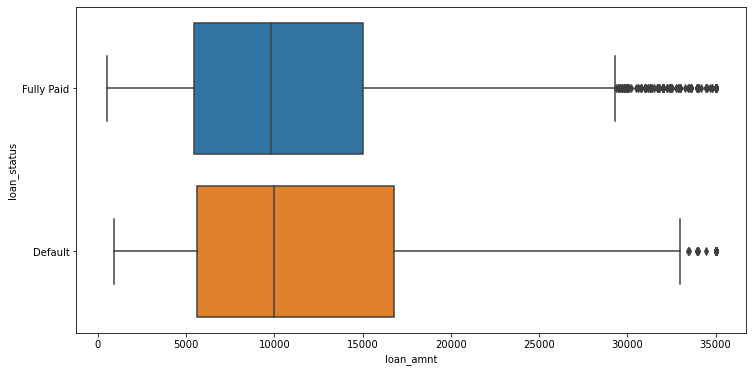

In [33]:
plt.figure(figsize=(12,6))
sns.boxplot(data['loan_amnt'],data['loan_status'])

In [34]:
# data.to_csv('DC1_1.csv',index=False)
# data=pd.read_csv('DC1_1.csv')

<AxesSubplot:xlabel='loan_status'>

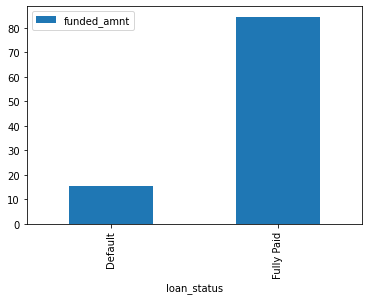

In [35]:
total_funded_amnt=data['funded_amnt'].sum()
(data[['funded_amnt','loan_status']].groupby(by='loan_status').\
         sum()/total_funded_amnt*100).plot(kind='bar')

#Around 23% of funded amount is defaulted

Now see how loan default rate and interest rate changes with grade and year.
I did following aggregations:
1. Default rate by grade
2. Default rate by year
3. Interest rate by grade
4. Interest rate by year

Following are the findings:
1. Default rate highly correlated with grade. Riskier the grade more is the chance to default
2. Defalut rate do not show any pattern with issue year, but it seems to relate with the economic conditions prevailing at that time. Also after 2010 the loans issued on site increased which also increased the loan defaulters. 2014 has peak default rate.
3. Interest rate is highly correlated with grade. Riskier the grade more is the interest rate.
4. Average interest rate is increasing. It is at peak in 2013 and 2014 which may be a reason for peak default rate in 2014 

In [42]:
def get_default_rate_by_col(column):
    """
    Param:
        column: str, column for which default rate is to be calculated for it's unique values. Column must have limited
        unique values.
    """
    tmp=pd.DataFrame(data[data['loan_status']=='Default'][column].value_counts()/data[column].value_counts())
    tmp.columns=[column+'_Default_Rate']
    tmp=tmp.join(data[column].value_counts())
    tmp.columns=[column+'_Default_Rate',column+'_Count']
    return tmp

In [43]:
# Create a column issue_year which has year in which the loan was issued.
data['issue_year']=data['issue_d'].apply(lambda x:int(x.split('-')[1]))

Text(0.5, 1.0, 'Default Rate Vs. Grade')

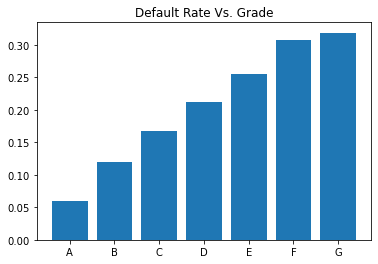

In [44]:
default_rate_by_grade=get_default_rate_by_col('grade')
plt.bar(x=default_rate_by_grade.index,height=default_rate_by_grade['grade_Default_Rate'])
plt.title('Default Rate Vs. Grade')

Text(0.5, 1.0, 'Default Rate Vs. Issue Year')

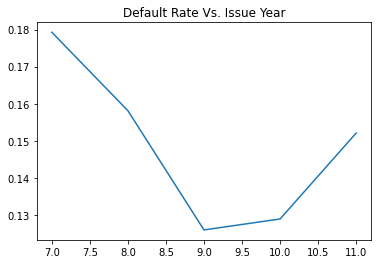

In [45]:
default_rate_by_year=get_default_rate_by_col('issue_year')
plt.plot(default_rate_by_year['issue_year_Default_Rate'].sort_index())
plt.title('Default Rate Vs. Issue Year')

In [46]:
interest_by_grade=data[['int_rate','grade']].groupby('grade').mean()
plt.bar(x=interest_by_grade.index,height=interest_by_grade['int_rate'])
plt.title('Interest Rate Vs. Grade')

KeyError: 'int_rate'

ZeroDivisionError: integer division or modulo by zero

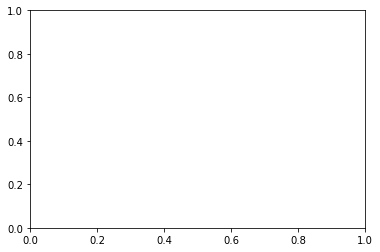

In [41]:
interest_by_year=data[['int_rate','issue_year']].groupby('issue_year').mean()
plt.plot(interest_by_year.sort_index())
plt.title('Interest Rate Vs. Year')

Look at the ** Return on Investment **

ROI = total_pymnt (amount returned by borrower) / funded_amnt

1. Total ROI is in negative as we are considering defaulted records also. As defaulted records generally have higher loan amounts, it moves overall ROI to negative side.
2. For riskier grades, overall ROI (incl. defaulted loans) decreases.
3. If we consider fully paid loans, then ROI is more for riskier grades.

In [31]:
tmp=data[['total_pymnt','funded_amnt','loan_status','grade']]
roi=(tmp['total_pymnt'].sum()/tmp['funded_amnt'].sum()-1)*100
print("ROI:",round(roi,2))

ROI: -2.65


In [32]:
tmp1=tmp.groupby('grade').sum()
ROI_by_grade=tmp1['total_pymnt']/tmp1['funded_amnt'] -1
ROI_by_grade

grade
A    0.034525
B    0.027576
C   -0.024436
D   -0.071834
E   -0.115351
F   -0.137799
G   -0.165548
dtype: float64

In [33]:
tmp=data[data['loan_status']=='Fully Paid'][['total_pymnt','funded_amnt','loan_status','grade']]
roi=(tmp['total_pymnt'].sum()/tmp['funded_amnt'].sum()-1)*100
print("ROI for fully paid loans:",round(roi,2))

ROI for fully paid loans: 14.13


In [34]:
#Gradewise ROI for fully paid loans
tmp1=tmp.groupby('grade').sum()
fully_paid_ROI_by_grade=tmp1['total_pymnt']/tmp1['funded_amnt'] -1
fully_paid_ROI_by_grade

grade
A    0.079777
B    0.125364
C    0.149117
D    0.175479
E    0.197441
F    0.228829
G    0.238275
dtype: float64

### Data Cleaning 1:
This is initial phase of data cleaning where I am dropping columns by looking at the their decription and the number of null values. As we want to predict loan_status when applicant applies for loan, I have deleted columns which leak information about future.
e.g. 'funded_amt', 'last_pymnt_amnt', 'installment', etc.

In [35]:
data_col[0:13]

,LoanStatNew,dtype,first value,Description,Nulls
0,id,int64,1077501,A unique LC assigned ID for the loan listing.,0
1,member_id,int64,1296599,A unique LC assigned Id for the borrower member.,0
2,loan_amnt,float64,5000,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",0
3,funded_amnt,float64,5000,The total amount committed to that loan at that point in time.,0
4,funded_amnt_inv,float64,4975,The total amount committed by investors for that loan at that point in time.,0
5,term,object,36 months,The number of payments on the loan. Values are in months and can be either 36 or 60.,0
6,int_rate,float64,10.65,Interest Rate on the loan,0
7,installment,float64,162.87,The monthly payment owed by the borrower if the loan originates.,0
8,grade,object,B,LC assigned loan grade,0
9,sub_grade,object,B2,LC assigned loan subgrade,0


In [36]:
#'grade' and 'sub_grade' gives same information
data.drop(['id','member_id','funded_amnt','funded_amnt_inv','installment','sub_grade','emp_title'],axis=1,inplace=True)

In [37]:
data_col[13:26]

,LoanStatNew,dtype,first value,Description,Nulls
13,annual_inc,float64,24000,The self-reported annual income provided by the borrower during registration.,4
14,verification_status,object,Verified,NaN,0
15,issue_d,object,Dec-2011,The month which the loan was funded,0
16,loan_status,object,Fully Paid,Current status of the loan,0
17,pymnt_plan,object,n,Indicates if a payment plan has been put in place for the loan,0
18,url,object,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,URL for the LC page with listing data.,0
19,desc,object,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,Loan description provided by the borrower,761351
20,purpose,object,credit_card,A category provided by the borrower for the loan request.,0
21,title,object,Computer,The loan title provided by the borrower,152
22,zip_code,object,860xx,The first 3 numbers of the zip code provided by the borrower in the loan application.,0


In [38]:
data.drop(['url','desc','title','zip_code'],axis=1,inplace=True)
#Info in 'title' and 'purpose' is same

In [39]:
data_col[26:39]

,LoanStatNew,dtype,first value,Description,Nulls
26,earliest_cr_line,object,Jan-1985,The month the borrower's earliest reported credit line was opened,29
27,inq_last_6mths,float64,1,The number of inquiries in past 6 months (excluding auto and mortgage inquiries),29
28,mths_since_last_delinq,float64,NaN,The number of months since the borrower's last delinquency.,454312
29,mths_since_last_record,float64,NaN,The number of months since the last public record.,750326
30,open_acc,float64,3,The number of open credit lines in the borrower's credit file.,29
31,pub_rec,float64,0,Number of derogatory public records,29
32,revol_bal,float64,13648,Total credit revolving balance,0
33,revol_util,float64,83.7,"Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.",502
34,total_acc,float64,9,The total number of credit lines currently in the borrower's credit file,29
35,initial_list_status,object,f,"The initial listing status of the loan. Possible values are – W, F",0


In [40]:
data.drop(['mths_since_last_delinq','mths_since_last_record','out_prncp','out_prncp_inv','total_pymnt'],
          axis=1,inplace=True)

In [41]:
data_col[39:52]

,LoanStatNew,dtype,first value,Description,Nulls
39,total_pymnt_inv,float64,5831.78,Payments received to date for portion of total amount funded by investors,0
40,total_rec_prncp,float64,5000,Principal received to date,0
41,total_rec_int,float64,861.07,Interest received to date,0
42,total_rec_late_fee,float64,0,Late fees received to date,0
43,recoveries,float64,0,post charge off gross recovery,0
44,collection_recovery_fee,float64,0,post charge off collection fee,0
45,last_pymnt_d,object,Jan-2015,Last month payment was received,17659
46,last_pymnt_amnt,float64,171.62,Last total payment amount received,0
47,next_pymnt_d,object,NaN,Next scheduled payment date,252971
48,last_credit_pull_d,object,Jan-2016,The most recent month LC pulled credit for this loan,53


In [42]:
data.drop(['total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries',
          'collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','next_pymnt_d','last_credit_pull_d','policy_code',
          'mths_since_last_major_derog'],
          axis=1,inplace=True)

In [43]:
data_col[52:65]

,LoanStatNew,dtype,first value,Description,Nulls
52,application_type,object,INDIVIDUAL,Indicates whether the loan is an individual application or a joint application with two co-borrowers,0
53,annual_inc_joint,float64,NaN,The combined self-reported annual income provided by the co-borrowers during registration,886868
54,dti_joint,float64,NaN,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income",886870
55,verification_status_joint,object,NaN,NaN,886868
56,acc_now_delinq,float64,0,The number of accounts on which the borrower is now delinquent.,29
57,tot_coll_amt,float64,NaN,Total collection amounts ever owed,70276
58,tot_cur_bal,float64,NaN,Total current balance of all accounts,70276
59,open_acc_6m,float64,NaN,Number of open trades in last 6 months,866007
60,open_il_6m,float64,NaN,Number of currently active installment trades,866007
61,open_il_12m,float64,NaN,Number of installment accounts opened in past 12 months,866007


In [44]:
# Drop any column with more than 50% missing values
data = data.dropna(thresh=(len(data)/2),axis=1) 

In [45]:
data_col[65:]
#These columns are already removed as they have more than 50% null values (except total_hi_rev_lim)

,LoanStatNew,dtype,first value,Description,Nulls
65,il_util,float64,NaN,Ratio of total current balance to high credit/credit limit on all install acct,868762
66,open_rv_12m,float64,NaN,Number of revolving trades opened in past 12 months,866007
67,open_rv_24m,float64,NaN,Number of revolving trades opened in past 24 months,866007
68,max_bal_bc,float64,NaN,Maximum current balance owed on all revolving accounts,866007
69,all_util,float64,NaN,Balance to credit limit on all trades,866007
70,total_rev_hi_lim,float64,NaN,NaN,70276
71,inq_fi,float64,NaN,Number of personal finance inquiries,866007
72,total_cu_tl,float64,NaN,Number of finance trades,866007
73,inq_last_12m,float64,NaN,Number of credit inquiries in past 12 months,866007


In [46]:
# data.to_csv('data_dc1.csv',index=False)

### Data Cleaning 2 : Null Imputation
After initial data cleaning, we're left with 30 columns. Now I did analysis of each column

In [47]:
# data=pd.read_csv('data_dc1.csv')
# data.head()

I calculated percent null values in each column.
1. Columns with null values : 'emp_length', 'revol_util', 'collections_12_mths_ex_med', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'
2. As 'emp_length' is ordinal variable, I encoded it according to value instead of creating dummy binary variables. 'emp_length' less that one year was set to 0 and that greater than 10 years was set to 10.
3. 'tot_coll_amt','tot_cur_bal','total_rev_hi_lim' have missing values till Sept-2012 date.
4. Other variables do not show any pattern in missing values

Check histograms of these columns. All of them are skewed with wide outliers.

In [48]:
nulls_percent=[]
for i in data.columns:
    tmp=len(data[data[i].isnull()])/len(data)*100
    nulls_percent.append(round(tmp,2))
null_df=pd.DataFrame(data=nulls_percent,index=data.columns,columns=['% Nulls'])
null_df[null_df['% Nulls']!=0]

,% Nulls
emp_length,4.02
revol_util,0.08
collections_12_mths_ex_med,0.02
tot_coll_amt,24.02
tot_cur_bal,24.02
total_rev_hi_lim,24.02


In [49]:
columns_with_nulls=['emp_length','revol_util','collections_12_mths_ex_med',\
                    'tot_coll_amt','tot_cur_bal','total_rev_hi_lim']

In [50]:
data['emp_length'].unique()

array(['10+ years', '< 1 year', '3 years', '9 years', '4 years',
       '5 years', '1 year', '6 years', '2 years', '7 years', '8 years',
       nan], dtype=object)

In [51]:
def encode_emp_length(x):
    if type(x)==float: #Check for nan ,as only Nans are float while other values are str
        return x
    if x=='10+ years':
        return 10
    if x=='< 1 year':
        return 0
    else:
        return int(x.split(' ')[0])
    
data['emp_length']=data['emp_length'].apply(encode_emp_length)

In [52]:
# for col in columns_with_nulls:
#     plt.figure(figsize=(8,6))
#     sns.distplot(data[data[col].notnull()][col])
#     plt.title('Histogram of {}'.format(col))

Looking at the histograms, columns can be imputed by median value.
I found that 'total_rev_hi_lim' is highly correlated with 'revol bal'.
So, I had two methods to impute 'total_rev_hi_lim'.
1. Impute by median value
2. Fit a polynomial between 'total_rev_hi_lim' and 'revol_bal'

As fitting a polynomial model didn't performed much better, I decided to go with method 1.
Code for method 2 is commented below.

In [53]:
corr_matrix=data.corr()
for col in columns_with_nulls:
    tmp=corr_matrix[col].apply(abs).sort_values(ascending=False)
    print(col, 'shows max correlation with',tmp.index[1],':',round(tmp[1],2))

emp_length shows max correlation with total_acc : 0.14
revol_util shows max correlation with int_rate : 0.34
collections_12_mths_ex_med shows max correlation with issue_year : 0.06
tot_coll_amt shows max correlation with revol_util : 0.01
tot_cur_bal shows max correlation with annual_inc : 0.44
total_rev_hi_lim shows max correlation with revol_bal : 0.83


In [54]:
# Fit a linear mode between 'total_rev_hi_lim' and 'revol_bal'

# from sklearn.metrics import mean_squared_error
# from scipy import polyfit,poly1d

# tmp1=data[data['total_rev_hi_lim'].notnull()][['revol_bal','total_rev_hi_lim']].copy()
# p=polyfit(tmp1['revol_bal'],tmp1['total_rev_hi_lim'],deg=2)
# poly=poly1d(p)
# tmp1['total_rev_hi_lim_pred']=tmp1['revol_bal'].apply(poly)
# print('RMSE:',np.sqrt(mean_squared_error(tmp1['total_rev_hi_lim'],tmp1['total_rev_hi_lim_pred'])))
# data['temp']=data['revol_bal'].apply(poly)

# i=data[data['total_rev_hi_lim'].isnull()].index
# data.loc[i,'total_rev_hi_lim']=data.loc[i,'temp']
# data.drop('temp',axis=1,inplace=True)


In [55]:
#Impute remaining columns with median

def impute_by_median(data,col):
    """
    Impute column by median value
    Params:
        data: Dataframe
        col: str, Name of column
    """
    med=data[col].median()
    data[col]=data[col].apply(lambda x: med if np.isnan(x) else x)

In [56]:
for col in columns_with_nulls:
    impute_by_median(data,col)

In [57]:
# data.to_csv('DC2.csv',index=False)

### Data Cleaning 3: Miscellaneous 
I went thought each and every column to see whether it is useful or not and did necessasry processing.
1. **'term'**: has only two values. I converted it to binary variable later.
2. **'grade'**: has 7 values. I created dummy variables for it.
3. **'home_ownership'**: Changed OHTER, NONE, ANY to RENT as these data points are too low.
4. **'verification_status'**: has 3 unique values. Created dummy variables.
5. **'pymnt_plan'**: only 6 rows have 'y' value. Dropped this column
6. **'purpose'**: has 14 unique values. Created dummy variables for it.
7. **'addr_state'**:

    There are total 51 states. So creating 50 dummy variables is not a wise choice. So, I did detailed analysis for 'addr_state'
    1. Some states having very less loans. So I considered states having more than 1000 loan applications.
    2. I calculated default rate per state and default rate per year per state.
    3. FL,LA,NV,IN : Higher default rate esp. after 2011
    4. CA,NY : avg. default rate, but number of loans are high CA, NY
    5. IL,GA,TX : Generally have lower default rate

   I decided to create dummy variables for these states: 'FL', 'NY', 'LA', 'NV', 'IN', 'CA', 'IL', 'GA', 'TX'

8. **'initial_list_status'**: don't seem to affect on 'loan_sttaus'. I dropped this column.
9. **'application_type'**: Almost all the values fall in one category. I dropped this column
10. **'earliest_cr_line'**: Changed it to the number of days before the loan issued i.e. number of days between 'issue_date' and 'earliest_cr_line'
11. Divide **'annual_inc', 'tot_cur_bal', 'total_rev_hi_lim', 'revol_bal'** by **'loan_amnt'**.
12. **'collections_12_mths_ex_med'**:  is very skewed with more than 90% values as 0.0. Also, default rate is similar for all values. I dropped this column as it is non-conclusive.

In [58]:
# data=pd.read_csv('DC2.csv')
# data.head()

In [59]:
# data.info()

In [60]:
data['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [61]:
data['grade'].value_counts()

B    78267
C    69019
D    43708
A    42835
E    21239
F     8507
G     2206
Name: grade, dtype: int64

In [62]:
#home_ownership
data['home_ownership'].value_counts()

MORTGAGE    130361
RENT        111928
OWN          23307
OTHER          141
NONE            43
ANY              1
Name: home_ownership, dtype: int64

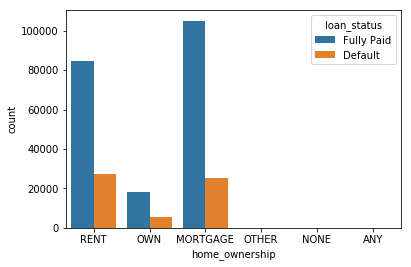

In [63]:
sns.countplot(x='home_ownership',hue='loan_status',data=data)

In [64]:
#Change OHTER, NONE, ANY to RENT as these data points are too low.
data['home_ownership']=data['home_ownership'].apply(lambda x: 'RENT' if x in ['OTHER','NONE','ANY'] else x)

In [65]:
#verification_status
data['verification_status'].value_counts()

Verified           97720
Not Verified       88863
Source Verified    79198
Name: verification_status, dtype: int64

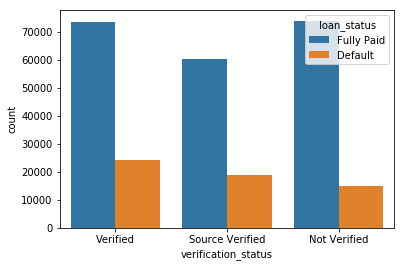

In [66]:
sns.countplot(x='verification_status',hue='loan_status',data=data)

In [67]:
#pymnt_plan
print(data['pymnt_plan'].value_counts())
data.drop('pymnt_plan',axis=1,inplace=True)

n    265775
y         6
Name: pymnt_plan, dtype: int64


In [68]:
#purpose
print("Unique values in purpose column:",data['purpose'].nunique())
data['purpose'].value_counts()

Unique values in purpose column: 14


debt_consolidation    156572
credit_card            52405
home_improvement       15638
other                  14937
major_purchase          6486
small_business          4955
car                     3726
medical                 2994
moving                  2129
wedding                 1963
house                   1720
vacation                1655
educational              325
renewable_energy         276
Name: purpose, dtype: int64

In [69]:
#Get the defalut rate for each laon purpose.
get_default_rate_by_col('purpose')
#Loans for small_business are highly probable to default.

,purpose_Default_Rate,purpose_Count
car,0.141707,3726
credit_card,0.193779,52405
debt_consolidation,0.228700,156572
educational,0.172308,325
home_improvement,0.190434,15638
house,0.205814,1720
major_purchase,0.168825,6486
medical,0.236807,2994
moving,0.247064,2129
other,0.240744,14937


In [70]:
#addr_state
print("Number of unique values in addr_state column:",data['addr_state'].nunique())
# data['addr_state'].value_counts()

Number of unique values in addr_state column: 51


In [71]:
default_rate_by_state=get_default_rate_by_col('addr_state')['addr_state_Default_Rate'].sort_values()

In [72]:
#Consider states with significant loan applications
# default_rate_by_state[data['addr_state'].value_counts()>1000]

In [73]:
#Check default rate per year per state
tmp1=data.groupby(by=['issue_year','addr_state']).count()['loan_amnt']
tmp2=data[data['loan_status']=='Default'].groupby(by=['issue_year','addr_state']).count()['loan_amnt']
default_rate_by_year_state=pd.DataFrame(tmp2/tmp1)
default_rate_by_year_state=default_rate_by_year_state.reset_index()
default_rate_by_year_state=default_rate_by_year_state.sort_values(by=['issue_year','loan_amnt'],ascending=[True,False])
default_rate_by_year_state=pd.DataFrame(default_rate_by_year_state)

#Add count of rows for each state to the dataframe
tmp=pd.DataFrame(data['addr_state'].value_counts())
tmp.columns=['count']
tmp.reset_index(inplace=True)
tmp.columns=['addr_state','count']
default_rate_by_year_state=pd.merge(default_rate_by_year_state,tmp,how='left',on='addr_state')
pd.DataFrame(default_rate_by_year_state).to_csv('default_rate_by_yar_state.csv',index=False)


In [74]:
#From above dataframe
states_to_keep=['FL','NY','LA','NV','IN','CA','IL','GA','TX']

#Create dummy variables for these states
for i in states_to_keep:
    data['state'+i]=data['addr_state'].apply(lambda x: 1 if x==i else 0)
data.drop('addr_state',axis=1,inplace=True)

f    189062
w     76719
Name: initial_list_status, dtype: int64


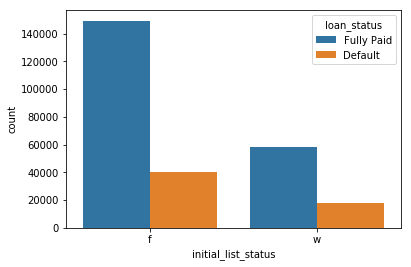

In [75]:
#initial_list_status
print(data['initial_list_status'].value_counts())
sns.countplot(x='initial_list_status',hue='loan_status',data=data)

In [76]:
print(get_default_rate_by_col('initial_list_status'))

data.drop('initial_list_status',axis=1,inplace=True)

   initial_list_status_Default_Rate  initial_list_status_Count
f                          0.211127                     189062
w                          0.236473                      76719


In [77]:
#application_type
print(data['application_type'].value_counts())
data.drop('application_type',axis=1,inplace=True)

INDIVIDUAL    265778
JOINT              3
Name: application_type, dtype: int64


In [78]:
#earliest_cr_line

#Change 'issue_d' and 'earliest_cr_line ' to datetime
from datetime import datetime as dt
data['issue_d']=data['issue_d'].apply(lambda x:dt.strptime('01-'+x,'%d-%b-%Y').date())
data['earliest_cr_line']=data['earliest_cr_line'].apply(lambda x:dt.strptime('01-'+x,'%d-%b-%Y').date())

In [79]:
data['earliest_cr_line']=data['issue_d']-data['earliest_cr_line']
data['earliest_cr_line']=data['earliest_cr_line'].apply(lambda x:int(str(x).split(' ')[0]))

In [80]:
#Divide 'annual_inc','tot_cur_bal','total_rev_hi_lim','revol_bal' by 'loan_amnt'
tmp=['annual_inc','tot_cur_bal','total_rev_hi_lim','revol_bal']
for col in tmp:
    data[col]=data[col]/data['loan_amnt']

In [81]:
#Create dummy variables for categorical columns
cat_cols=['term','grade','home_ownership','verification_status','purpose']
for col in cat_cols:
    data=data.join(pd.get_dummies(data[col],drop_first=True))
data.drop(cat_cols,axis=1,inplace=True)

In [82]:
# collections_12_mths_ex_med
# get_default_rate_by_col('collections_12_mths_ex_med')

In [83]:
data.drop('collections_12_mths_ex_med',axis=1,inplace=True)

In [84]:
# data.to_csv('DC3.csv',index=False)

### Data Cleaning 4: Handling Outliers 
In this section I have checked for the outliers. Outliers may force our machine learning model to overfit. Handling outliers features helps to decrease the effect of outliers on machine learning model.

An easy way to detect outliers is to plot a box plot.

There are many ways to handle the outliers like:
1. Delete the rows with outliers
2. Cap the features with outliers i.e. set some max value for that feature and cap the outliers at that value.
3. Apply some transformations (mostly log or boxcox transformation) to feature and convert it to a near normal distribution.

Instead of applying a single strategy to all features, I analysed them and then applied suitable strategy. If feature had extreme outliers, I considered deleting or capping those rows otherwise I applied transformations.

Handling outliers itself can be another major task, but I have not much focused on it for this project.

In [85]:
# data=pd.read_csv('DC3.csv')
# data.head()

As an example I will explain how did I handle outliers for columns : 

**1. int_rate**

#get_default_rate_by_col('int_rate')

As interest rate increases, default rate is also increasing. So, outliers in this case can be helpful to predict defaulter.

For interest rate > 25 around 50% loans are default.

So, I've transformed this feature.

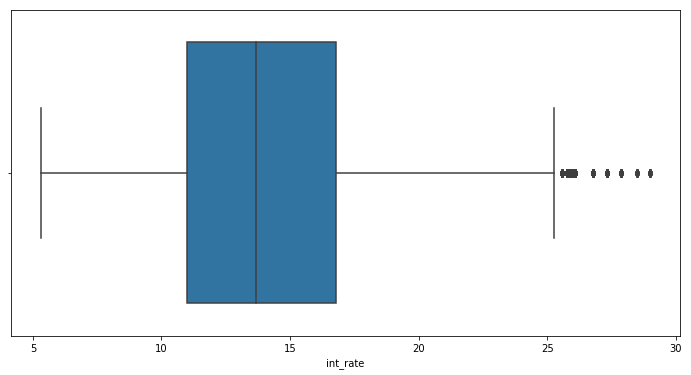

In [86]:
#int_rate
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
sns.boxplot(x='int_rate',data=data,ax=ax)

#The points outside the whiskers of boxplot represents outliers.

In [87]:
data[data['int_rate']>25]['loan_status'].value_counts()

Default       1116
Fully Paid    1112
Name: loan_status, dtype: int64

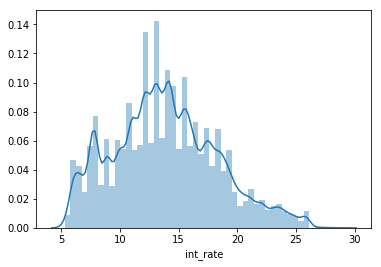

In [88]:
sns.distplot(data['int_rate'])

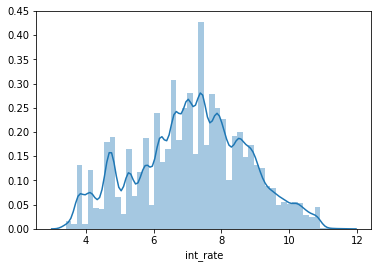

In [89]:
sns.distplot(data['int_rate'].apply(lambda x: np.log1p(x)**2))

In [90]:
data['int_rate']=data['int_rate'].apply(lambda x: np.log1p(x)**2)

**2. dti**

There is only one value greate than 40 which is 57.14. It is an extreme outlier, so I removed it. There is no need to apply any distribution.

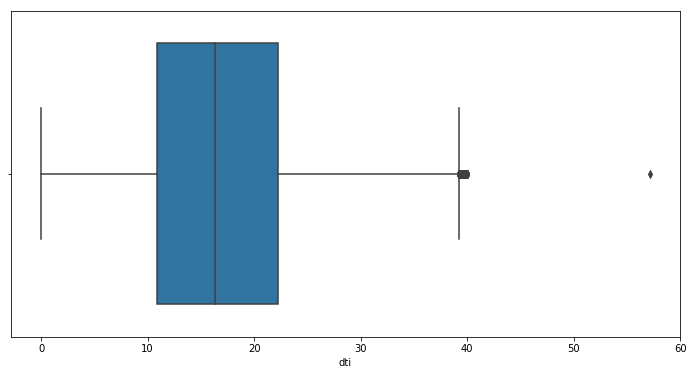

In [91]:
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
sns.boxplot(x='dti',data=data,ax=ax)

In [92]:
data=data[data['dti']<40].reset_index(drop=True)

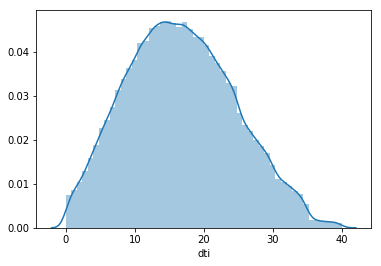

In [93]:
sns.distplot(data['dti'])

In this way I have handled outliers in the data. Some bullet points are: 

1. Instances with higher delinquency are too low to get any conclusion.
2. As number of inquiries increases, we can see increase in default rate. But, higher 'inq_last_6mths' values have  too low instances. Same is the case for 'open_acc'
3. Values with high 'revol_bal' have less defaulters. But values are much spreaded after 40.

I can't mention all the steps here. I have added the final code of outlier removal in 'lending_club.data_cleaning.py' file.

In [94]:
from lending_club.data_cleaning import Transform_Skewed_Features
transformer=Transform_Skewed_Features()
data=transformer.fit_transform(data)

In [95]:
# data.to_csv('DC4.csv',index=False)

### Data Cleaning 5: Multicolinearity

I have also checked for multi-colinearity in data. Multicoliearity can be checked from variance Inflation Factor (vif). Basically, it detects highly correlated features from the data. Presence of highly correlated features in data will overfit the machine learning model. So, it is necessary to remove such features from data.

But, removing all such features may not always help and even in worst case it can make the model worse. So, it is always good to train model in both cases or try changing thrshold of vif. I have not much focused on this part. 

I have already written code for this in my another project [California House Price Prediction](https://github.com/sonarsushant/California-House-Price-Prediction). I have added this code to 'lending_club.data_analysis.py' file.

In [96]:
# data=pd.read_csv('DC4.csv')
# data.head()

In [97]:
y=data['loan_status'].apply(lambda x: 1 if x=='Default' else 0)

In [98]:
data.drop(['loan_status','issue_d','issue_year'],axis=1,inplace=True)

In [99]:
from lending_club.data_cleaning import remove_by_vif

In [100]:
# remove_by_vif(data)

In [101]:
columns_removed_by_vif=['loan_amnt','int_rate','annual_inc','total_acc','revol_bal',
                        'debt_consolidation','total_rev_hi_lim','tot_cur_bal','open_acc'
                        'revol_util','earliest_cr_line',]

### Next Steps:
1. Prepare data for machine learning algorithm
    1. Create a pipeline to do all the data cleaning I did in this notebook
    2. Split data into train and test set
    3. Applying SMOTE technique. (I have explained this in next notebook)
    4. Standard scaling of data
    
    
2. Training machine learning algorithms